In [78]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import datetime
import warnings
warnings.filterwarnings(action='ignore')

import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

In [79]:
def load_split_data(start_date: str, end_date: str):
    covid = pd.read_csv('project_data_preprocessed.csv')
    covid['Date'] = pd.to_datetime(covid['Date_reported'])
    covid = covid.set_index(covid['Date'])

    train = covid.loc[start_date:end_date]
    test  = covid.loc[end_date:]
    print('Train Dataset:',train.shape)
    print('Test Dataset:',test.shape)

    train = train.drop(['Unnamed: 0', 'Date_reported', ' Country', 'Date'], axis=1)
    test = test.drop(['Unnamed: 0', 'Date_reported', ' Country', 'Date'], axis=1)
    covid = covid.drop(['Unnamed: 0', 'Date_reported', ' Country', 'Date'], axis=1)
    return covid, train, test

In [80]:
def train_test(train, test):
    X_train, X_test, y_train, y_test = \
    train[train.columns[:-1]].to_numpy(), test[test.columns[:-1]].to_numpy(), train[train.columns[-1]].to_numpy(), test[test.columns[-1]].to_numpy()
    return X_train, X_test, y_train, y_test

In [81]:
def create_model(X, y, X_train, X_test, y_train, y_test, params, cv=False):
    rfc = RandomForestClassifier(n_estimators = 500, max_features = 'sqrt')
    if cv:
        scores = cross_validate(rfc, X, y, cv=10,
                                scoring=(
                                    'r2', 'neg_mean_squared_error', 'accuracy'),
                                return_train_score=True)
        print('Mean train and test accuracy scores:',
              scores['train_accuracy'].mean(), scores['test_accuracy'].mean())
        print('Mean train and test r2 scores:',
              scores['train_r2'].mean(), scores['test_r2'].mean())
        print('Mean train and test negative mse scores:', scores['train_neg_mean_squared_error'].mean(
        ), scores['test_neg_mean_squared_error'].mean())
    else:
        rfc.fit(X_train, y_train)
        y_pred = rfc.predict(X_test)
        print('Accuracy score for random forest: ',
              accuracy_score(y_pred, y_test))
    return rfc

In [82]:
def grid_search(estimator, parameters, X, y):
    clf = GridSearchCV(estimator, parameters)
    clf.fit(X, y)
    print(clf.cv_results_)

In [83]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    _, axes = plt.subplots(figsize=(10, 5))

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt

Train Dataset: (2153, 31)
Test Dataset: (19, 31)
Mean train and test accuracy scores: 1.0 0.7371607782898104
Mean train and test r2 scores: 1.0 0.6221321792123347
Mean train and test negative mse scores: 0.0 -0.26422811059907836


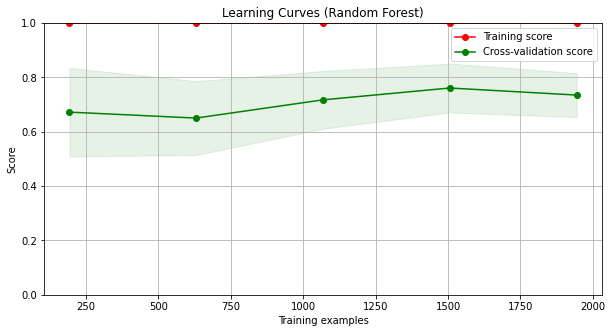

In [84]:
def main():
    covid, train, test = load_split_data('2020-01-01', '2020-08-18')
    X_train, X_test, y_train, y_test = train_test(train, test)

    X = covid[covid.columns[:-1]].to_numpy()
    y = covid[covid.columns[-1]].to_numpy()

    rf_params = {'n_estimators': [50, 100, 200, 300, 400, 500],
    'max_depth': [2, 5, 10, 20],
    'criterion': ('gini','entropy'),
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'max_features': ('auto','sqrt','log2','None'),
    'max_leaf_nodes': [1, 2, 3, 4, 5],
    'class_weight': ('balanced','None')}

    rfc = create_model(X, y, X_train, X_test, y_train, y_test, rf_params, cv=True)
    #grid_search(RandomForestClassifier(), rf_params, X_train, y_train)

    title = "Learning Curves (Random Forest)"
    # Cross validation with 100 iterations to get smoother mean test and train
    # score curves, each time with 20% data randomly selected as a validation set.
    cv = ShuffleSplit(n_splits=100, test_size=0.33, random_state=0)

    plot_learning_curve(rfc, title, X, y, ylim=(0.0, 1.00),
                        cv=10, n_jobs=4)

    plt.show()


if __name__ == "__main__":
    main()